# Running Tests

In [1]:
from game.GridGeneration import DisjointBlobs
from htn.my_htn import DictBasedHTN
import matplotlib.pyplot as plt
import numpy as np

## Maze Complexity Analysis
The following code investigate how well the HTN performs as maze complexity increases for the current obstacles that means more blobs and greater blob masses.

In [22]:
max_counts = range(1, 11)
max_sizes = range(2, 21, 2)
num_episodes = 200
base_seed = 42

avg_lengths = np.zeros((len(max_sizes), len(max_counts)))

for i, max_size in enumerate(max_sizes):
    print(i)
    for j, max_count in enumerate(max_counts):
        lengths: list[int] = []
        for k in range(num_episodes):
            seed = base_seed + k
            obstacle_gen = DisjointBlobs(
                max_count=max_count,
                max_size=max_size,
            )
            game = DictBasedHTN(
                h=18,
                w=18,
                n=9,
                m=9,
                num_fake_targets=0,
                obstacle_scheme=obstacle_gen,
            )
            game_len = game.play_game(seed=seed)
            lengths.append(game_len)
        avg_lengths[i, j] = np.mean(lengths)
        print(f"max_count={max_count}, max_size={max_size} -> avg_len={avg_lengths[i,j]:.2f}")

0
max_count=1, max_size=2 -> avg_len=103.08
max_count=2, max_size=2 -> avg_len=104.06
max_count=3, max_size=2 -> avg_len=104.42
max_count=4, max_size=2 -> avg_len=103.25
max_count=5, max_size=2 -> avg_len=103.00
max_count=6, max_size=2 -> avg_len=101.62
max_count=7, max_size=2 -> avg_len=102.27
max_count=8, max_size=2 -> avg_len=102.33
max_count=9, max_size=2 -> avg_len=101.67
max_count=10, max_size=2 -> avg_len=103.33
1
max_count=1, max_size=4 -> avg_len=103.52
max_count=2, max_size=4 -> avg_len=103.58
max_count=3, max_size=4 -> avg_len=100.89
max_count=4, max_size=4 -> avg_len=101.12
max_count=5, max_size=4 -> avg_len=101.52
max_count=6, max_size=4 -> avg_len=99.84
max_count=7, max_size=4 -> avg_len=101.61
max_count=8, max_size=4 -> avg_len=100.78
max_count=9, max_size=4 -> avg_len=99.73
max_count=10, max_size=4 -> avg_len=97.72
2
max_count=1, max_size=6 -> avg_len=103.56
max_count=2, max_size=6 -> avg_len=101.44
max_count=3, max_size=6 -> avg_len=101.70
max_count=4, max_size=6 -> av

### Plot the data

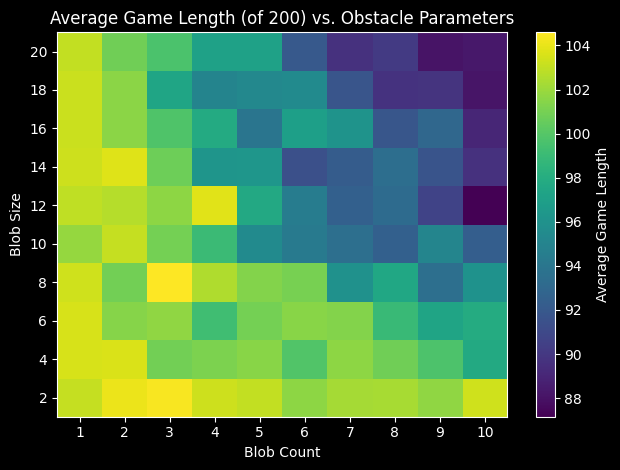

In [24]:
# ---- Visualization as heat map ----
fig, ax = plt.subplots()

# imshow will use the default colormap; no custom colors specified
im = ax.imshow(avg_lengths, origin="lower", aspect="auto")

# Tick labels correspond to your parameter values
ax.set_xticks(np.arange(len(max_counts)))
ax.set_xticklabels(max_counts)
ax.set_yticks(np.arange(len(max_sizes)))
ax.set_yticklabels(max_sizes)

ax.set_xlabel("Blob Count")
ax.set_ylabel("Blob Size")
ax.set_title("Average Game Length (of 200) vs. Obstacle Parameters")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Game Length")

plt.tight_layout()
plt.show()

## Maze Vision Ability Analysis
The following code investigate how well the HTN performs as the agent's vision ability increases ie it can see farther in the maze.

In [11]:
small_board_results: list[float] = []
medium_board_results: list[float] = []
large_board_results: list[float] = []

obstacle_gen = DisjointBlobs(
    max_count=5,
    max_size=5,
)

base_seed = 42

for i in range(3, 12, 2):
    print(i)
    game = DictBasedHTN(
        h=12,
        w=12,
        n=i,
        m=1000,
        num_fake_targets=5,
        obstacle_scheme=obstacle_gen,
    )
    game_len = []
    small_board_results.append(sum(game.play_game(seed=base_seed+k) for k in range(200)) / 200)
    
    game = DictBasedHTN(
        h=24,
        w=24,
        n=i,
        m=1000,
        num_fake_targets=5,
        obstacle_scheme=obstacle_gen,
    )
    game_len = []
    medium_board_results.append(sum(game.play_game(seed=base_seed+k) for k in range(200)) / 200)
    
    game = DictBasedHTN(
        h=36,
        w=36,
        n=i,
        m=1000,
        num_fake_targets=5,
        obstacle_scheme=obstacle_gen,
    )
    game_len = []
    large_board_results.append(sum(game.play_game(seed=base_seed+k) for k in range(200)) / 200)


3
5
7
9
11


### Plotting individually

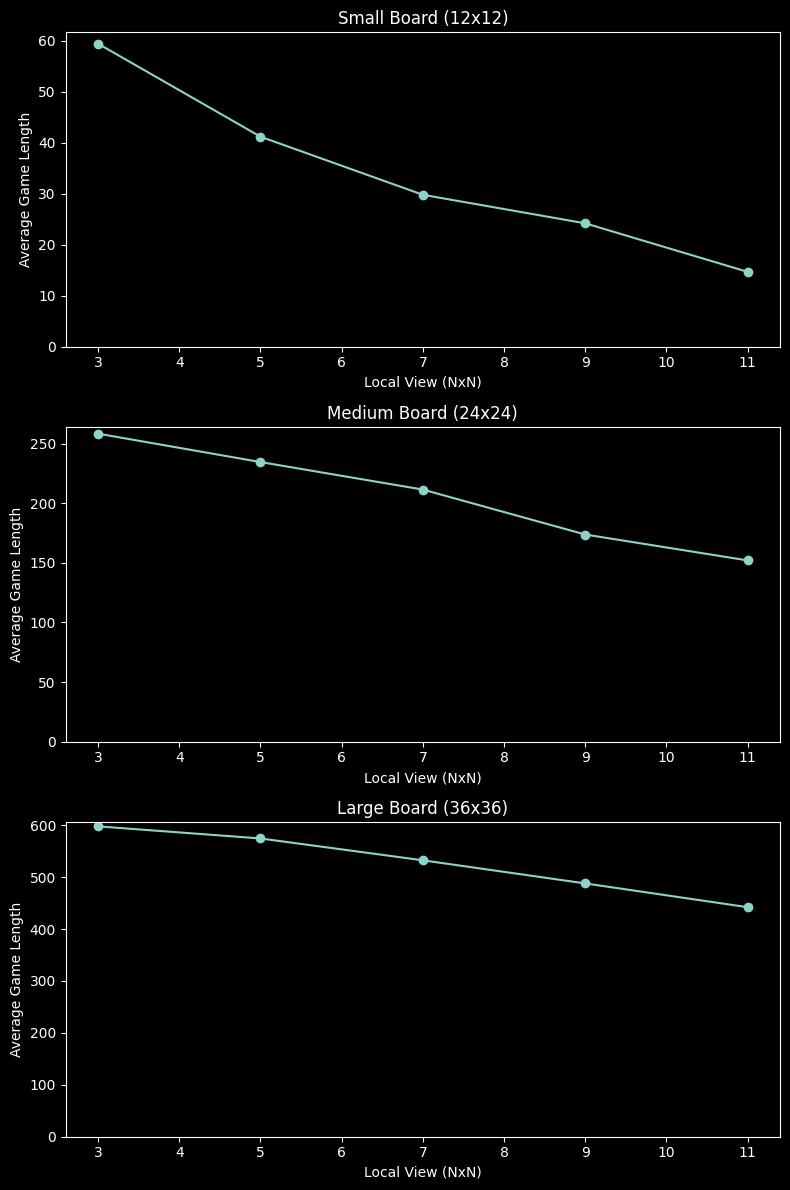

In [9]:
viewing_distances = list(range(3, 12, 2))

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].plot(viewing_distances, small_board_results, marker='o')
axes[0].set_title('Small Board (12x12)')
axes[0].set_xlabel('Local View (NxN)')
axes[0].set_ylabel('Average Game Length')
axes[0].set_ylim(bottom=0)

axes[1].plot(viewing_distances, medium_board_results, marker='o')
axes[1].set_title('Medium Board (24x24)')
axes[1].set_xlabel('Local View (NxN)')
axes[1].set_ylabel('Average Game Length')
axes[1].set_ylim(bottom=0)

axes[2].plot(viewing_distances, large_board_results, marker='o')
axes[2].set_title('Large Board (36x36)')
axes[2].set_xlabel('Local View (NxN)')
axes[2].set_ylabel('Average Game Length')
axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

### Plotting together

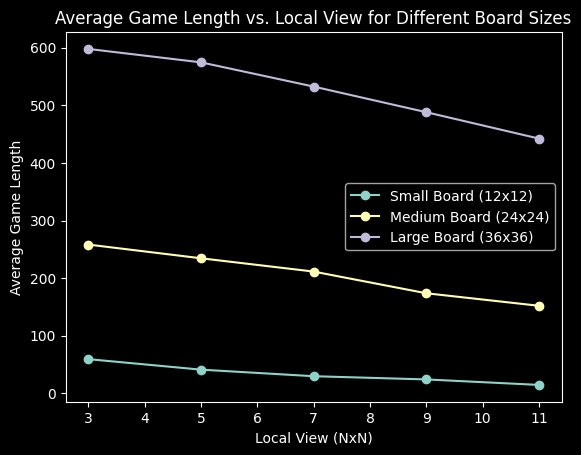

In [10]:
plt.plot(viewing_distances, small_board_results, marker='o', label='Small Board (12x12)')
plt.plot(viewing_distances, medium_board_results, marker='o', label='Medium Board (24x24)')
plt.plot(viewing_distances, large_board_results, marker='o', label='Large Board (36x36)')
plt.xlabel('Local View (NxN)')
plt.ylabel('Average Game Length')
plt.title('Average Game Length vs. Local View for Different Board Sizes')
plt.legend()
plt.show()